# 기본과제 - DistilBERT로 뉴스 기사 분류 모델 학습하기

In [2]:
!pip install -qU tqdm boto3 requests regex sentencepiece sacremoses datasets

그 후, 우리가 사용하는 DistilBERT pre-training 때 사용한 tokenizer를 불러옵니다.

In [3]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader

# DistilBERT 모델용 tokenizer 로드 (pretrained)
# 이 tokenizer는 문장을 토큰화해서 모델이 이해할 수 있는 input_ids로 변환해줌
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'distilbert-base-uncased')

/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/huggingface/pytorch-transformers/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://hu

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

# AG News dataset 준비

https://huggingface.co/datasets/fancyzhx/ag_news

label : World (0), Sports (1), Business (2), Sci/Tech (3)

In [5]:
# AG News 데이터셋의 5%만 로드 (학습 데이터와 테스트 데이터 각각)
train_ds = load_dataset("fancyzhx/ag_news", split="train[:5%]")
test_ds = load_dataset("fancyzhx/ag_news", split="test[:5%]")

# 뉴스 카테고리 확인
# 'label' 값들을 모아서 중복되지 않는 값들을 찾아냅니다.
labels = [item['label'] for item in train_ds]  # train_ds에 있는 모든 item에서 'label' 값만 뽑아서 labels 리스트에 저장
unique_labels = set(labels)  # labels 리스트를 set으로 변환하여 중복 값 제거

# 중복되지 않는 label의 개수를 출력합니다.
print(f"뉴스 카테고리 개수: {len(unique_labels)}")  # unique_labels의 길이를 출력하여 카테고리 개수 확인

# 중복되지 않는 label들을 출력합니다.
print(f"고유한 label들: {unique_labels}")  # unique_labels에 있는 값들을 출력하여 어떤 카테고리가 있는지 확인


뉴스 카테고리 개수: 4
고유한 label들: {0, 1, 2, 3}


`Collate_fn` 함수에 Truncation과 관련된 부분들을 지우기.

truncation True -> False 로 변경

In [6]:
# 데이터를 배치로 묶기 위한 함수 정의
def collate_fn(batch):
    max_len = 400  # 입력 문장의 최대 길이 설정
    texts, labels = [], []  # 입력 문장들과 라벨들을 저장할 리스트

    # 배치 내 각 샘플에 대해 text와 label 추출
    for row in batch:
        labels.append(row['label'])
        texts.append(row['text'])

    # tokenizer로 텍스트를 토큰화하고, 최대 길이로 패딩 및 자르기
    # tokenizer는 사전에 정의되어 있어야 함 (예: tokenizer = AutoTokenizer.from_pretrained(...))
    # Tuncation 삭제: 원래 BERT/DistilBERT 사용 시 문장 길이가 너무 길면 자르곤 한다, 이번엔 truncation 하지 않고 데이터를 그대로 학습하도록 수정하라는 의미.
    texts = torch.LongTensor(
        tokenizer(texts, padding=True, truncation=False, max_length=max_len).input_ids
    )

    # 라벨 리스트를 LongTensor로 변환
    labels = torch.LongTensor(labels)

    # 모델 학습에 필요한 입력 (토큰화된 문장들)과 정답 라벨 반환
    return texts, labels

# 학습용 DataLoader 정의 (shuffle=True로 배치 순서 랜덤화)
train_loader = DataLoader(
    train_ds, batch_size=64, shuffle=True, collate_fn=collate_fn
)

# 테스트용 DataLoader 정의 (shuffle=False로 배치 순서 고정)
test_loader = DataLoader(
    test_ds, batch_size=64, shuffle=False, collate_fn=collate_fn
)

# pre-trained DistilBERT를 불러오기

이번에는 PyTorch hub에서 제공하는 DistilBERT를 불러봅시다.

In [7]:
#DistilBERT 모델을 PyTorch Hub에서 로드 후 model 출력
model = torch.hub.load('huggingface/pytorch-transformers', 'model', 'distilbert-base-uncased')
model

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

# Classifier output, loss function, accuracy function 변경

먼저 Cassifier output과 loss function 을 변경


In [13]:
from torch import nn

# 텍스트 분류 모델 정의 (DistilBERT + Linear layer)
class TextClassifier(nn.Module):
    def __init__(self):
        super().__init__()

        # 사전학습된 DistilBERT 모델을 encoder로 불러옴 (pretrained transformer)
        self.encoder = torch.hub.load('huggingface/pytorch-transformers', 'model', 'distilbert-base-uncased')


        # [CLS] 토큰 분류기 정의 1 -> 4
        self.classifier = nn.Linear(768, 4)

    def forward(self, x):
        # encoder에 input_ids 전달
        x = self.encoder(x)['last_hidden_state']

        # [CLS] 토큰 위치 벡터를 classification head에 전달
        x = self.classifier(x[:, 0])

        return x  # logit 출력

model = TextClassifier()

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


In [14]:
for param in model.encoder.parameters():
  param.requires_grad = False

# 학습 및 시각화

In [19]:
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt
from torch import nn

# 학습 함수 정의
def train(model, train_loader, loss_fn, optimizer, n_epochs):
    train_losses = []  # 학습 손실 저장
    train_accs = []  # 학습 정확도 저장

    for epoch in range(n_epochs):
        total_loss = 0.
        model.train()  # 학습 모드 설정

        for data in train_loader:
            model.zero_grad()  # 이전 gradient 초기화

            inputs, labels = data
            inputs, labels = inputs.to('cuda'), labels.to('cuda').float()

            preds = model(inputs)
            loss = loss_fn(preds, labels.long())  # 손실 계산
            loss.backward()  # 역전파
            optimizer.step()  # 파라미터 업데이트

            total_loss += loss.item()  # loss 누적

        train_losses.append(total_loss)  # 학습 손실 저장
        train_acc = accuracy(model, train_loader)  # 학습 정확도 계산
        train_accs.append(train_acc)  # 학습 정확도 저장

        print(f"Epoch {epoch:3d} | Train Loss: {total_loss:.4f} | Train Acc: {train_acc:.4f}")

    return train_losses, train_accs

In [20]:
# 정확도 계산 함수
def accuracy(model, dataloader):
    cnt = 0      # 전체 샘플 수
    acc = 0      # 정답 개수 누적

    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        preds = model(inputs)  # 로짓(logit) 출력

        # 가장 높은 확률을 가진 클래스를 예측값으로 선택
        preds = torch.argmax(preds, dim=-1)

        cnt += labels.shape[0]  # 총 샘플 수 누적
        acc += (labels == preds).sum().item()  # 예측이 맞은 수 누적

    return acc / cnt  # 정확도 반환


# 시각화 함수 정의
def visualize_training(train_losses, train_accs):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


# 평가 함수 정의
def evaluate(model, train_loader, test_loader):
    # 평가 시 gradient 계산 비활성화
    with torch.no_grad():
      model.eval()  # 평가 모드로 전환 (계산 비활성화)
      train_acc = accuracy(model, train_loader)
      test_acc = accuracy(model, test_loader)

      print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")

    return train_acc, test_acc

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch   0 | Train Loss: 41.5898 | Train Acc: 0.8540
Epoch   1 | Train Loss: 40.5976 | Train Acc: 0.8517
Epoch   2 | Train Loss: 40.1677 | Train Acc: 0.8580
Epoch   3 | Train Loss: 40.3788 | Train Acc: 0.8518
Epoch   4 | Train Loss: 40.0869 | Train Acc: 0.8548
Epoch   5 | Train Loss: 39.3827 | Train Acc: 0.8557
Epoch   6 | Train Loss: 39.9161 | Train Acc: 0.8588
Epoch   7 | Train Loss: 39.0888 | Train Acc: 0.8540
Epoch   8 | Train Loss: 38.8778 | Train Acc: 0.8592
Epoch   9 | Train Loss: 38.3058 | Train Acc: 0.8612


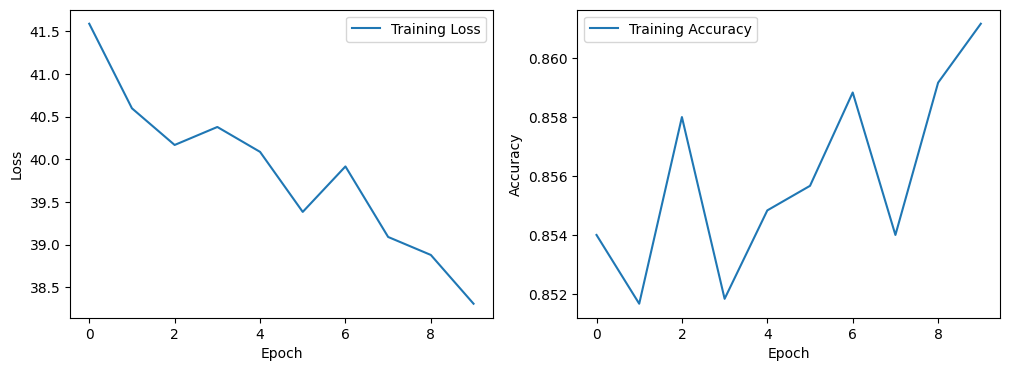

=========> Train acc: 0.868 | Test acc: 0.863


In [21]:
# 학습 설정
lr = 0.001
model = model.to('cuda')
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=lr)
n_epochs = 10

# 학습 실행
train_losses, train_accs = train(model, train_loader, loss_fn, optimizer, n_epochs)

# 학습 시각화
visualize_training(train_losses, train_accs)

# 평가 실행
test_acc = evaluate(model, train_loader, test_loader)

In [23]:
# 입력 텍스트
# input_text = "The stock market is down today."
input_text = "today's economy"

# DistilBERT 모델을 사용하여 입력 텍스트 분류
input_ids = tokenizer(input_text, return_tensors='pt').input_ids.to('cuda')
with torch.no_grad():
    logits = model(input_ids)
predicted_class = torch.argmax(logits, dim=-1).item()

# 분류 결과에 따라 LLM 모델에서 생성된 답변 선택
if predicted_class == 0:  # World
    response = "There is a lot of news about the stock market today."
elif predicted_class == 1:  # Sports
    response = "I don't have any information about sports."
elif predicted_class == 2:  # Business
    response = "The stock market is an important indicator of the economy."
elif predicted_class == 3:  # Sci/Tech
    response = "I don't have any information about science and technology."

# 답변 출력
print(response)

The stock market is an important indicator of the economy.
